In [18]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt

df = pd.read_csv("OpenSSH_2k.log_structured.csv")
print(df.head())
print(df.info())


   LineId Date  Day      Time Component    Pid  \
0       1  Dec   10  06:55:46     LabSZ  24200   
1       2  Dec   10  06:55:46     LabSZ  24200   
2       3  Dec   10  06:55:46     LabSZ  24200   
3       4  Dec   10  06:55:46     LabSZ  24200   
4       5  Dec   10  06:55:46     LabSZ  24200   

                                             Content EventId  \
0  reverse mapping checking getaddrinfo for ns.ma...     E27   
1         Invalid user webmaster from 173.234.31.186     E13   
2  input_userauth_request: invalid user webmaster...     E12   
3      pam_unix(sshd:auth): check pass; user unknown     E21   
4  pam_unix(sshd:auth): authentication failure; l...     E19   

                                       EventTemplate  
0  reverse mapping checking getaddrinfo for <*> [...  
1                          Invalid user <*> from <*>  
2  input_userauth_request: invalid user <*> [prea...  
3      pam_unix(sshd:auth): check pass; user unknown  
4  pam_unix(sshd:auth): authentication 

**Descriptive analysis**

Columns: ['LineId', 'Date', 'Day', 'Time', 'Component', 'Pid', 'Content', 'EventId', 'EventTemplate']

Data types:
 LineId            int64
Date             object
Day               int64
Time             object
Component        object
Pid               int64
Content          object
EventId          object
EventTemplate    object
dtype: object

Missing values (%):
 LineId           0.0
Date             0.0
Day              0.0
Time             0.0
Component        0.0
Pid              0.0
Content          0.0
EventId          0.0
EventTemplate    0.0
dtype: float64

Top EventId values:
 EventId
E24    413
E20    384
E9     383
E10    135
E21    135
E13    113
E12    113
E19    110
E27     85
E7      45
Name: count, dtype: int64

Sample log lines:


,Content
0,reverse mapping checking getaddrinfo for ns.ma...
1,Invalid user webmaster from 173.234.31.186
2,input_userauth_request: invalid user webmaster...
3,pam_unix(sshd:auth): check pass; user unknown
4,pam_unix(sshd:auth): authentication failure; l...


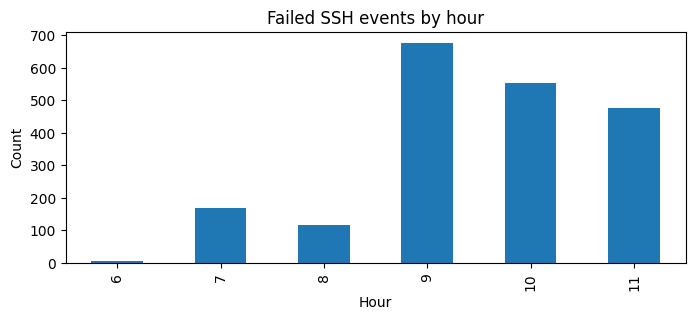


FailureType distribution:
 FailureType
Other                745
Disconnected         471
Failed password      385
Invalid user         365
Connection closed     34
Name: count, dtype: int64

Top 10 source IPs:
 Ip
183.62.140.253     867
187.141.143.180    349
103.99.0.122       172
112.95.230.3        80
5.188.10.180        53
185.190.58.151      43
123.235.32.19       22
52.80.34.196        15
60.2.12.12          15
103.207.39.212      12
Name: count, dtype: int64

Top 10 targeted users:
 User
unknown           135
admin              87
authentication     45
support            18
oracle             18
test               15
user               12
0                  10
1234                9
guest               9
Name: count, dtype: int64

Distinct EventId count: 27


,EventId,Ip,User,FailureType
0,E27,173.234.31.186,NaN,Other
1,E13,173.234.31.186,webmaster,Invalid user
2,E12,NaN,webmaster,Invalid user
3,E21,NaN,unknown,Other
4,E19,173.234.31.186,NaN,Other
5,E10,173.234.31.186,webmaster,Invalid user
6,E2,173.234.31.186,NaN,Connection closed
7,E2,212.47.254.145,NaN,Connection closed
8,E13,52.80.34.196,test9,Invalid user
9,E12,NaN,test9,Invalid user


In [19]:
# --- Basic stats ---
print("Columns:", list(df.columns))
print("\nData types:\n", df.dtypes)
print("\nMissing values (%):\n", (df.isna().mean()*100).round(2).sort_values(ascending=False))

print("\nTop EventId values:\n", df["EventId"].value_counts().head(10))
print("\nSample log lines:")
display(df["Content"].head(5))

# --- Some data on Time column ---
if "Time" in df.columns:
    df["Time"] = pd.to_datetime(df["Time"], format="%H:%M:%S", errors="coerce")
    df["Hour"] = df["Time"].dt.hour
    ax = df["Hour"].value_counts().sort_index().plot(kind="bar", figsize=(8,3))
    ax.set_title("Failed SSH events by hour")
    ax.set_xlabel("Hour")
    ax.set_ylabel("Count")
    plt.show()

df["Ip"]   = df["Content"].str.extract(r'(\d{1,3}(?:\.\d{1,3}){3})')
df["User"] = df["Content"].str.extract(r'\buser\s+(\w+)\b', flags=re.IGNORECASE)


def detect_failure_type(msg: str) -> str:
    m = str(msg).lower()
    if "invalid user" in m:      return "Invalid user"
    if "failed password" in m:   return "Failed password"
    if "connection closed" in m: return "Connection closed"
    if "disconnect" in m:        return "Disconnected"
    if "error" in m:             return "Other error"
    return "Other"

df["FailureType"] = df["Content"].apply(detect_failure_type)

# --- STATS ---
print("\nFailureType distribution:\n", df["FailureType"].value_counts())
print("\nTop 10 source IPs:\n", df["Ip"].value_counts().head(10))
print("\nTop 10 targeted users:\n", df["User"].value_counts().head(10))
print("\nDistinct EventId count:", df["EventId"].nunique())

df[["EventId","Ip","User","FailureType"]].head(10)


**Implementation of the Necessary Preprocessing**

In [23]:
import re
import pandas as pd
import numpy as np


if "Time" in df.columns:
    df["Time"] = pd.to_datetime(df["Time"], format="%H:%M:%S", errors="coerce")
    df["Hour"] = df["Time"].dt.hour
else:

    if "Hour" not in df.columns:
        df["Hour"] = -1

df["ip"] = df["Content"].str.extract(r'(\d{1,3}(?:\.\d{1,3}){3})')
df["user"] = df["Content"].str.extract(r'\buser\s+(\w+)\b', flags=re.IGNORECASE)
df["port"] = df["Content"].str.extract(r'\bport\s+(\d+)\b').astype(float)  # temporary float to handle NaN
df["preauth"] = df["Content"].str.contains(r"\[preauth\]", case=False, na=False)

# Clean
df["user"] = df["user"].fillna("unknown")
df["ip"]   = df["ip"].fillna("0.0.0.0")
df["port"] = df["port"].fillna(0).astype(int)

df["conn_per_hour"] = df.groupby(["ip", "Hour"])["ip"].transform("count")


event_col = "EventId" if "EventId" in df.columns else ("Eventid" if "Eventid" in df.columns else None)
if event_col is None:
    raise KeyError("Neither 'EventId' nor 'Eventid' found in the dataframe.")

normal_events = {"E1", "E2", "E22", "E23", "E24", "E25", "E26"}
df["connection_type"] = df[event_col].apply(lambda x: "N" if str(x) in normal_events else "S")


cols_to_keep = [event_col, "ip", "user", "port", "preauth", "Hour", "conn_per_hour", "connection_type", "Content"]
df = df[[c for c in cols_to_keep if c in df.columns]].copy()

print(df.head(10))
print("\nconnection_type distribution:\n", df["connection_type"].value_counts())


  EventId              ip       user   port  preauth  Hour  conn_per_hour  \
0     E27  173.234.31.186    unknown      0    False     6              5   
1     E13  173.234.31.186  webmaster      0    False     6              5   
2     E12         0.0.0.0  webmaster      0     True     6              2   
3     E21         0.0.0.0    unknown      0    False     6              2   
4     E19  173.234.31.186    unknown      0    False     6              5   
5     E10  173.234.31.186  webmaster  38926    False     6              5   
6      E2  173.234.31.186    unknown      0     True     6              5   
7      E2  212.47.254.145    unknown      0     True     7              1   
8     E13    52.80.34.196      test9      0    False     7              6   
9     E12         0.0.0.0      test9      0     True     7             22   

  connection_type                                            Content  
0               S  reverse mapping checking getaddrinfo for ns.ma...  
1         

#Problematique

Chaques jours, les systèmes informatiques enregistre de nombreuses connexion et stockent les informations les concernant dans des journaux que l'on appel "Log". Certaines de ces connexions peuvent correspondre à des tentatives d'accès non autorisées, et les annalyser peut donc permettre de renforcer la sécurité des systèmes pour detecter les comportements suspects.

Dans ce projet, nous allons donc analyser des logs d'authentification SSH afin de détecter des activités anormales, comm les tentatices répétées de connexion.

Notre jeu de données contient de nombreuses informations qui ne nous serons pas utile comme le Pid (inutile car toutes les connexions ont été enregistrées sur la meme machine) et dont nous nous sommes donc débarassé. La colonne "Content" contenait quand à elle de nombreuses informations mais innexploitable car sous forme de texte, nous l'avons donc éclatée en plusieurs colonnes comme "IP". Enfin nous avons calculer le nombre de connexion d'un Ip par heure pour reperer les tentatives repétées et nous avons classifier les differents event (type d'échec ou de réussite de connexion) en deux categorie Suspect "S" ou Normal "N".


**Selection and Implementation of a Baseline Model**

Binary baseline (Normal vs Suspect)

=== Baseline Binary Classification (Normal vs Suspect) ===
              precision    recall  f1-score   support

      Normal      0.991     1.000     0.996       115
     Suspect      1.000     0.997     0.999       385

    accuracy                          0.998       500
   macro avg      0.996     0.999     0.997       500
weighted avg      0.998     0.998     0.998       500



/usr/local/lib/python3.12/dist-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


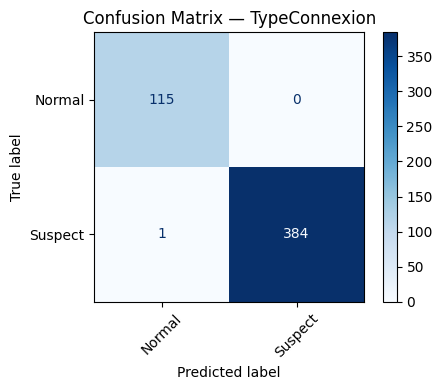

In [25]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split


if y_bin.nunique() >= 2:
    num_cols  = ["Port"]
    bool_cols = ["PreAuth"]
    cat_cols  = ["Ip","User","EventId"]

    # Preprocessing: One-hot encode categorical data
    prepro = ColumnTransformer([
        ("num", "passthrough", num_cols),
        ("bool","passthrough", bool_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore", min_frequency=5), cat_cols)
    ])

    model = Pipeline([
        ("prep", prepro),
        ("clf", LogisticRegression(max_iter=300))
    ])

    # Split dataset
    X_train, X_test, y_train, y_test = train_test_split(
        X_bin, y_bin, test_size=0.25, random_state=42, stratify=y_bin
    )

    # Train and evaluate
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    print("=== Baseline Binary Classification (Normal vs Suspect) ===")
    print(classification_report(y_test, y_pred, digits=3))

    # Confusion matrix
    fig, ax = plt.subplots(figsize=(5,4))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap="Blues", xticks_rotation=45)
    ax.set_title("Confusion Matrix — TypeConnexion")
    plt.tight_layout()
    plt.show()
else:
    print("Binary classification not possible (only one class). Proceeding to multiclass model.")


Multiclass baseline (FailureType)

=== Multiclass Baseline: FailureType (TF-IDF + Linear SVM) ===
                   precision    recall  f1-score   support

Connection closed      1.000     1.000     1.000         9
     Disconnected      1.000     1.000     1.000       118
  Failed password      1.000     1.000     1.000        96
     Invalid user      1.000     1.000     1.000        91
            Other      1.000     1.000     1.000       186

         accuracy                          1.000       500
        macro avg      1.000     1.000     1.000       500
     weighted avg      1.000     1.000     1.000       500



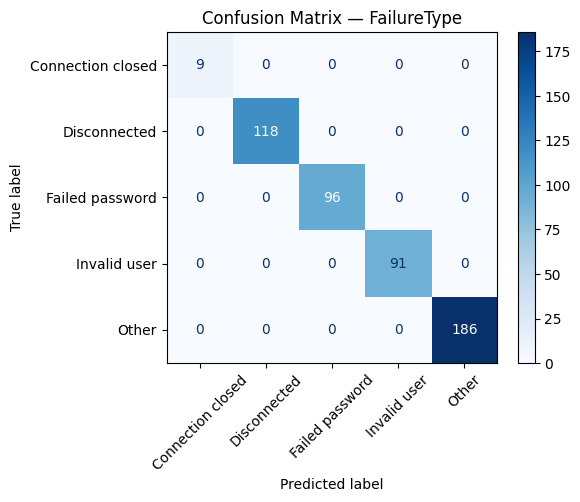


Top terms for class 'Connection closed':
   186 preauth
   151 preauth
   by 185
   by
   connection
   closed
   closed by
   connection closed

Top terms for class 'Disconnected':
   bye bye
   preauth
   11
   disconnect from
   received
   received disconnect
   disconnect
   bye

Top terms for class 'Failed password':
   ssh2
   port
   password for
   password
   root
   failed password
   for root
   root from

Top terms for class 'Invalid user':
   from
   user admin
   support from
   admin from
   user
   for invalid
   invalid
   invalid user

Top terms for class 'Other':
   receive identification
   uid
   sshd auth
   pam_unix sshd
   pam_unix
   pam
   sshd
   fztu


In [34]:
# --- Multiclass baseline: classify FailureType from Content (TF-IDF + Linear SVM) ---


from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import make_pipeline
from sklearn.svm import LinearSVC
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path
import pandas as pd

if "FailureType" not in df.columns:

    if "Content" not in df.columns:
        RAW_PATH = Path("OpenSSH_2k.log_structured.csv")
        df_raw = pd.read_csv(RAW_PATH)
        df = df.reset_index(drop=True); df_raw = df_raw.reset_index(drop=True)
        df["Content"] = df_raw["Content"]

    def detect_failure_type(msg: str) -> str:
        m = str(msg).lower()
        if "invalid user" in m:      return "Invalid user"
        if "failed password" in m:   return "Failed password"
        if "connection closed" in m: return "Connection closed"
        if "disconnect" in m:        return "Disconnected"
        if "error" in m:             return "Other error"
        return "Other"
    df["FailureType"] = df["Content"].apply(detect_failure_type)


if df["FailureType"].nunique() < 2:
    print("Only one FailureType present — multiclass baseline not meaningful.")
else:

    X = df["Content"].astype(str)
    y = df["FailureType"].astype(str)
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.25, random_state=42, stratify=y
    )


    clf = make_pipeline(
        TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95),
        LinearSVC()
    )

    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    # Metrics
    print("=== Multiclass Baseline: FailureType (TF-IDF + Linear SVM) ===")
    print(classification_report(y_test, y_pred, digits=3))

    # Confusion matrix
    fig, ax = plt.subplots(figsize=(6,5))
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, ax=ax, cmap="Blues", xticks_rotation=45)
    ax.set_title("Confusion Matrix — FailureType")
    plt.tight_layout(); plt.show()

    # Top terms per class (quick interpretability)
    vec = clf.named_steps["tfidfvectorizer"]
    svm = clf.named_steps["linearsvc"]
    feature_names = np.array(vec.get_feature_names_out())
    classes = svm.classes_
    for i, c in enumerate(classes):
        coefs = svm.coef_[i]
        top_idx = np.argsort(coefs)[-8:]
        print(f"\nTop terms for class '{c}':")
        for t in feature_names[top_idx]:
            print("  ", t)
